# 課題1

**変更点**
* Motionクラスを作成し、motion.updateで更新する
* Sensorクラスを作成し、sensor.updateで観測する
* samplingを関数化

In [1]:
%matplotlib inline
import numpy as np
import math, random, copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

In [2]:
class Particle:
    def __init__(self,p,w):
        self.pose = np.array(p)
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)

particles = [Particle([0.0,0.0,0.0],1.0/100) for i in range(100)]

In [3]:
class Robot:
    def __init__(self,x,y,theta):
        self.pose = np.array([x, y, theta])
        self.color = "black"
robot = Robot(0.0, 0.0, 0.0)

In [4]:
class Landmark:
    def __init__(self,x,y):
        self.pos = np.array([x, y])
        self.color = "orange"
landmarks = [Landmark(-0.5, 0.0),Landmark(0.0, 0.5),Landmark(0.5, 0.0)]

In [5]:
class Motion:
    def __init__(self):
        self.u = np.array([0.2,math.pi / 180.0 * 20])
    
    def update(self,x_old):
        pos_x, pos_y, pos_theta = x_old
        act_fw, act_rot = self.u

        act_fw = random.gauss(act_fw,act_fw/10)
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
        act_rot = random.gauss(act_rot,act_rot/10)

        pos_x += act_fw * math.cos(pos_theta + dir_error)
        pos_y += act_fw * math.sin(pos_theta + dir_error)
        pos_theta += act_rot

        return np.array([pos_x,pos_y,pos_theta]) 

motion = Motion()

In [6]:
class Sensor:
    def update(self, pose, landmarks):
        ms = self.observations(pose,landmarks)
        return ms
    
    def relative_landmark_pos(self,pose,landmark):
        x,y,theta = pose
        lx,ly = landmark
        distance = math.sqrt((x -lx)**2 + (y-ly)**2)
        direction = math.atan2(ly-y, lx-x) - theta

        return (distance, direction,lx,ly) # 実際の位置も一緒に返す
        
    def likelihood(self, pose, measurement):
        x,y,theta = pose
        distance, direction,lx,ly = measurement
        # パーティクルの姿勢から観測されるはずのランドマークの距離と向き
        rel_distance, rel_direction, tmp_x,tmp_y = self.relative_landmark_pos(pose,(lx,ly))
        # 誤差をガウスで評価
        return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
                 * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)

    def change_weights(self, particles, measurement):
        for p in particles:
            p.weight *= self.likelihood(p.pose, measurement)
        # 重みの合計を1に保つ
        ws = [ p.weight for p in particles ]
        s = sum(ws)
        for p in particles: p.weight = p.weight / s
    
    def observation(self, pose, landmark):
        actual_distance,actual_direction,lx,ly = self.relative_landmark_pos(pose,landmark)

        # 方向の制限（cosの値が正）
        if (math.cos(actual_direction) < 0.0):
            return None
        
        measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
        measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)  

        return (measured_distance, measured_direction,lx,ly)

    def observations(self, pose,landmarks):
        return filter(lambda x: x != None, [ self.observation(pose,e.pos) for e in landmarks])

sensor = Sensor()

In [7]:
def sampling(particles):
    accum = []
    sm = 0.0
    for p in particles:
        accum.append(p.weight + sm)
        sm += p.weight
    new_particles = []
    particles_num = len(particles)
    pointer = random.uniform(0.0,1.0/len(particles))
    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose),1.0/particles_num)
            )
            pointer += 1.0/particles_num
        else:
            accum.pop(0)
            particles.pop(0)
    return new_particles
particles = sampling(particles)

In [8]:
def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

def draw_particles(particles):
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles] 
    vys = [math.sin(e.pose[2])*e.weight for e in particles] 
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
def draw_landmarks(landmarks):
    xs = [ e.pos[0] for e in landmarks]
    ys = [ e.pos[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

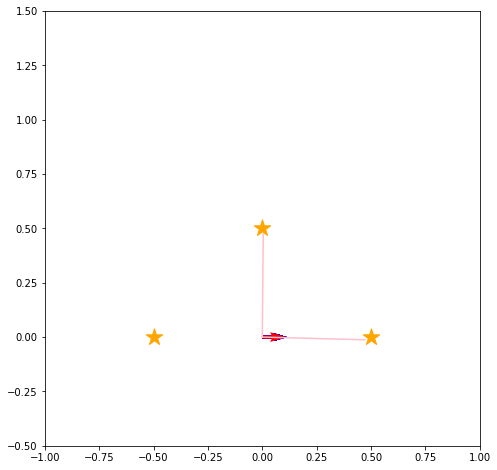

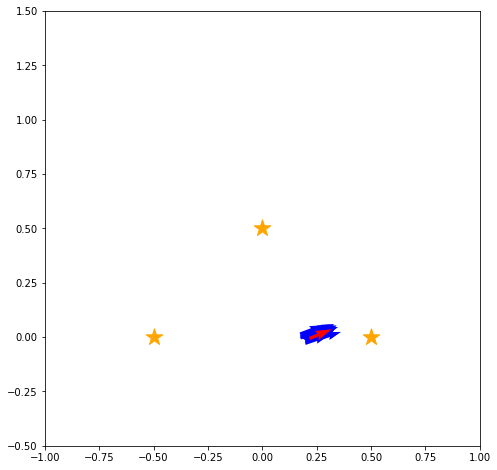

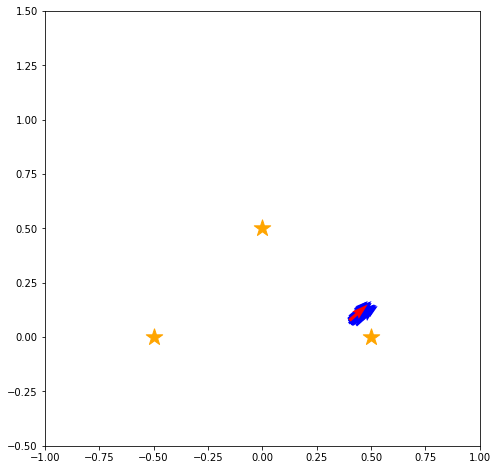

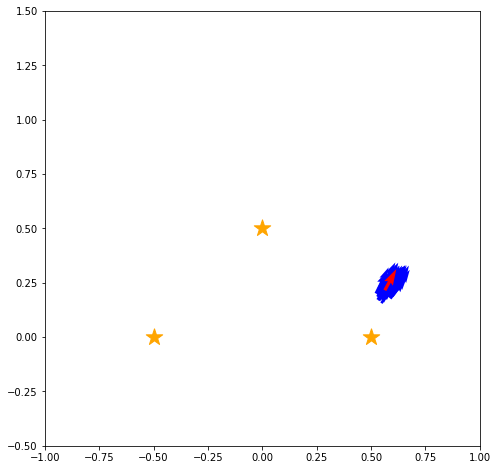

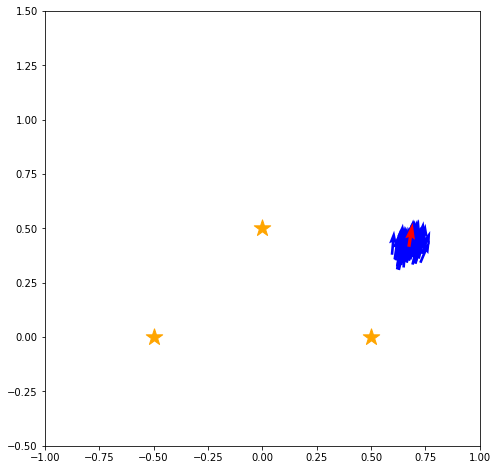

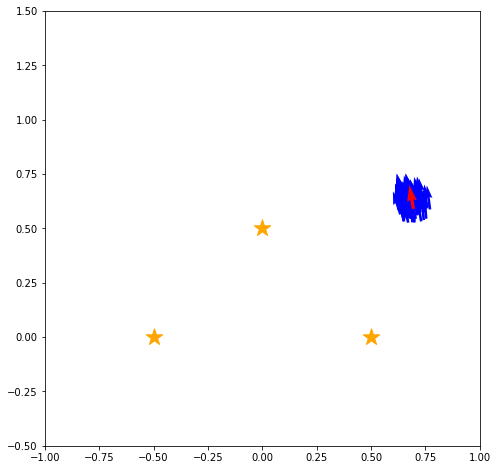

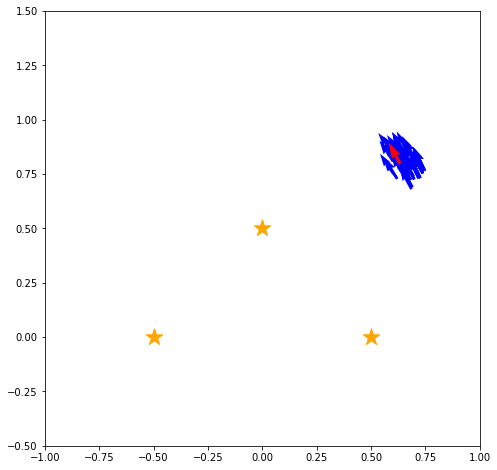

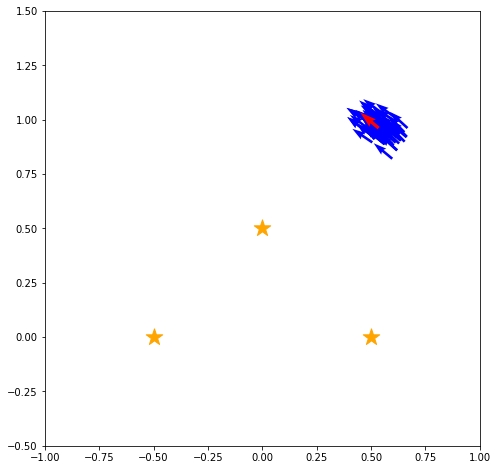

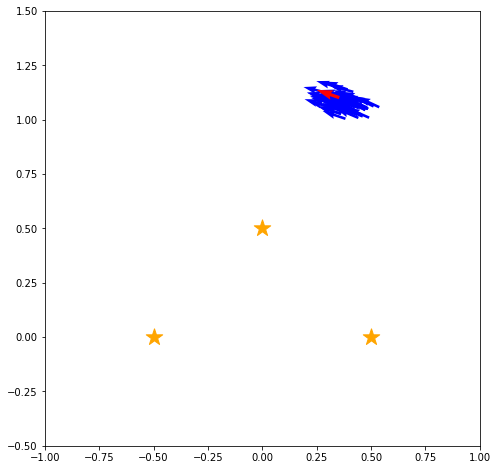

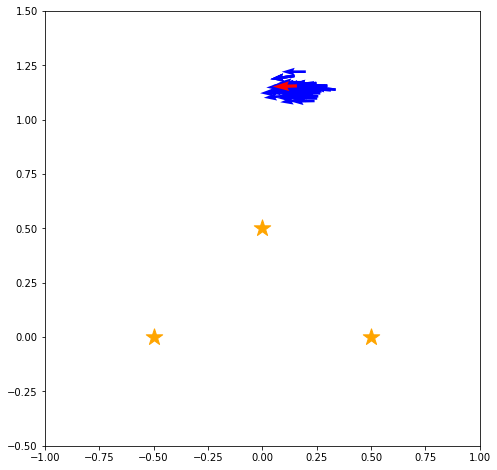

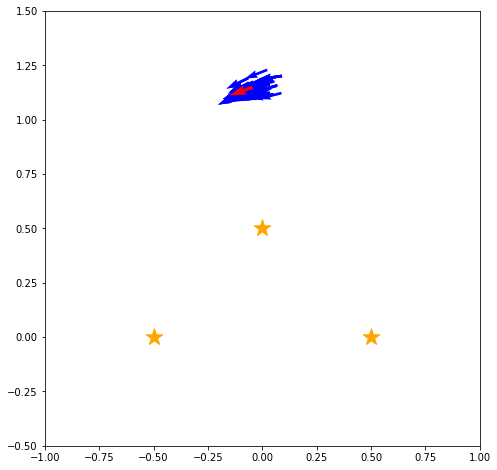

In [9]:
path = [robot.pose]
particle_path = [copy.deepcopy(particles)]
mss  = [sensor.update(robot.pose, landmarks)]

for itr in range(10):
    robot.pose = motion.update(robot.pose)
    measurments = sensor.update(robot.pose, landmarks)
    for p in particles:
        p.pose = motion.update(p.pose)
    for m in measurments:
        sensor.change_weights(particles, m)
    particles = sampling(particles)
    path.append(robot.pose)
    particle_path.append(copy.deepcopy(particles))
    mss.append(measurments)

for i,p in enumerate(path):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    draw_particles(particle_path[i])
    draw_landmarks(landmarks)
    draw_robot(path[i])
    draw_observations(path[i],mss[i])